In [71]:
import os
import re
import collections
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats

if os.getcwd().endswith('notebook'):
    os.chdir('..')

In [2]:
sns.set(palette='colorblind', font_scale=1.3)
palette = sns.color_palette()

## Assemblies

In [3]:
assemblies_path = os.path.join(os.getcwd(), 'data/assemblies.csv')
assembly_df = pd.read_csv(assemblies_path, index_col='assembly_accession')
assemblies = np.array(assembly_df.index.tolist())
assembly_df.head()

,taxid,species_taxid,organism_name,domain,phylum,class,order,family,genus,species,strain,assembly_level
assembly_accession,,,,,,,,,,,,
GCA_000010525.1,438753,7,Azorhizobium caulinodans ORS 571,Bacteria,Proteobacteria,Alphaproteobacteria,Rhizobiales,Xanthobacteraceae,Azorhizobium,Azorhizobium caulinodans,Azorhizobium caulinodans ORS 571,Complete Genome
GCA_000218545.1,593907,11,Cellulomonas gilvus ATCC 13127,Bacteria,Actinobacteria,Actinobacteria,Micrococcales,Cellulomonadaceae,Cellulomonas,Cellulomonas gilvus,Cellulomonas gilvus ATCC 13127,Complete Genome
GCA_000020965.1,309799,14,Dictyoglomus thermophilum H-6-12,Bacteria,Dictyoglomi,Dictyoglomia,Dictyoglomales,Dictyoglomaceae,Dictyoglomus,Dictyoglomus thermophilum,Dictyoglomus thermophilum H-6-12,Complete Genome
GCA_000012885.1,338963,19,Pelobacter carbinolicus DSM 2380,Bacteria,Proteobacteria,Deltaproteobacteria,Desulfuromonadales,Desulfuromonadaceae,Pelobacter,Pelobacter carbinolicus,Pelobacter carbinolicus DSM 2380,Complete Genome
GCA_001735525.1,23,23,Shewanella colwelliana,Bacteria,Proteobacteria,Gammaproteobacteria,Alteromonadales,Shewanellaceae,Shewanella,NaN,Shewanella colwelliana,Scaffold


## Plot distribution of distances for a specific strain

In [27]:
e_coli_assembly = assembly_df[assembly_df['organism_name'].str.contains('Escherichia coli')].index[0]
e_coli_assembly

'GCA_000800765.1'

In [28]:
klebsiella_aerogenes_assembly = assembly_df[
    assembly_df['organism_name'].str.contains('Klebsiella aerogenes')
].index[0]
klebsiella_aerogenes_assembly

'GCA_000215745.1'

In [57]:
dictyoglomus_thermophilum_assembly = assembly_df[
    assembly_df['organism_name'].str.contains('Dictyoglomus thermophilum')
].index[0]
dictyoglomus_thermophilum_assembly

'GCA_000020965.1'

In [84]:
def load_gene_dist(assembly):
    gene_dist_path = os.path.join(
        os.getcwd(),
        f'data/sequences/{assembly}/{assembly}_tri_nucleotide_distance_to_mean.csv',
    )
    dist = pd.read_csv(gene_dist_path)
    return dist, dist['distance'].values

In [39]:
def load_genome_wide_distance(assembly):
    dist_path = os.path.join(
        os.getcwd(),
        f'data/tri_nucleotide_dist_genome_wide_with_overlap.csv',
    )
    df = pd.read_csv(dist_path, index_col='assembly_accession')
    return df.loc[assembly].values

In [86]:
def load_protein_families(assembly, query_type):
    source_path = os.path.join(
        os.getcwd(),
        f'data/sequences/{assembly}/{assembly}_{query_type}.csv.gz',
    )
    return pd.read_csv(source_path, index_col='query')

In [78]:
def kl_divergence(p, q, axis=0):
    return scipy.stats.entropy(p, q, axis=axis)


def jensen_shannon_distance(p, q, axis=0):
    m = (p + q) / 2
    a = kl_divergence(p, m, axis)
    b = kl_divergence(q, m, axis)
    return np.sqrt(
        np.clip(
            (a + b) / 2,
            a_min=0,
            a_max=None,
        )
    )

In [79]:
klebsiella_aerogenes_distribution = load_genome_wide_distance(klebsiella_aerogenes_assembly)
dictyoglomus_thermophilum_distribution = load_genome_wide_distance(dictyoglomus_thermophilum_assembly)
e_coli_distribution = load_genome_wide_distance(e_coli_assembly)

klebsiella_aerogenes_distance = jensen_shannon_distance(
    e_coli_distribution, 
    klebsiella_aerogenes_distribution,
)
dictyoglomus_thermophilum_distance = jensen_shannon_distance(
    e_coli_distribution, 
    dictyoglomus_thermophilum_distribution,
)

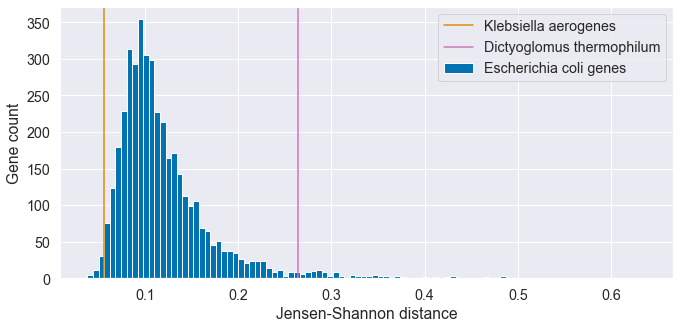

In [85]:
e_coli_genes_df, e_coli_distances = load_gene_dist(e_coli_assembly)

f, ax = plt.subplots(1, 1, figsize=(11, 5))
ax.hist(e_coli_distances, bins=100, label='Escherichia coli genes');
ax.axvline(klebsiella_aerogenes_distance, color=palette[1], label='Klebsiella aerogenes');
ax.axvline(dictyoglomus_thermophilum_distance, color=palette[4], label='Dictyoglomus thermophilum');
ax.legend();
ax.set_xlabel('Jensen-Shannon distance');
ax.set_ylabel('Gene count');
#f.savefig(
#    os.path.join(os.getcwd(), 'report/diagrams/e_coli_distances.eps'), 
#    bbox_inches='tight', 
#    dpi=300,
#)

In [88]:
e_coli_pfam = load_protein_families(e_coli_assembly, 'pfam')
e_coli_pfam.head()

,assembly_accession,protein_id,query_id,label
query,,,,
MreC,GCA_000800765.1,AIZ53040.1,PF04085.14,cell-wall-structural-complex-MreBCD-transmembr...
MreD,GCA_000800765.1,AIZ53039.1,PF04093.12,cell-wall-structural-complex-MreBCD-transmembr...
MR_MLE_C,GCA_000800765.1,AIZ53504.1,PF13378.6,galactonate-dehydratase
MR_MLE_C,GCA_000800765.1,AIZ51372.1,PF13378.6,bifunctional-D-altronate/D-mannonate-dehydratase
MR_MLE_C,GCA_000800765.1,AIZ52590.1,PF13378.6,"glucarate-dehydratase-related-protein,-substra..."


In [91]:
len(e_coli_pfam.loc['PAS'])

11

## Sample accession and plot

In [5]:
def sample_assemblies(assemblies, n_samples, seed=None):
    rs = np.random.RandomState(seed)
    return rs.choice(assemblies, replace=False, size=n_samples)

In [183]:
def plot_domain_distances(
    assembly_df, 
    domain_query, 
    query_type,
    n_samples, 
    tail='left',
    phylum=None,
    n_cols=3, 
    seed=None,
):
    n_rows = int(np.ceil(n_samples / n_cols))
    
    f, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
    axes = axes.flatten()
    n_axes = len(axes)
    
    if phylum is not None:
        assemblies = assembly_df[assembly_df['phylum'] == phylum].index
    else:
        assemblies = assembly_df.index
    
    sampled_assemblies = sample_assemblies(assemblies, n_samples, seed)
    
    for i, assembly in enumerate(sampled_assemblies):
        ax = axes[i]
        if (i+1) > n_axes:
            ax.remove()
            continue
            
        gene_dist_path = os.path.join(
            os.getcwd(),
            f'data/sequences/{assembly}/{assembly}_tri_nucleotide_distance_to_mean.csv',
        )
        gene_dist = pd.read_csv(gene_dist_path)
            
        if query_type == 'pfam':
            source_path = os.path.join(
                os.getcwd(),
                f'data/sequences/{assembly}/{assembly}_pfam.csv.gz',
            )
        else:
            source_path = os.path.join(
                os.getcwd(),
                f'data/sequences/{assembly}/{assembly}_tigr.csv.gz',
            )
            
        domain_source = pd.read_csv(source_path)
        
        protein_ids = domain_source[domain_source['query'] == domain_query]['protein_id'].values

        distances = gene_dist['distance'].values
        ax.hist(distances, bins=100, alpha=1, label='genes');

        mean = np.mean(distances)
        ax.axvline(mean, color=palette[4], alpha=1, label='genes mean', linewidth=3)

        for j, v in enumerate(gene_dist[gene_dist['protein_id'].isin(protein_ids)]['distance'].values):
            if tail == 'left':
                color = 'green' if v < mean else 'red'
            else:
                color = 'green' if v > mean else 'red'
                
            label = None
            if j == 0:
                label = domain_query
                
            ax.axvline(v, color=palette[1], alpha=1, label=label);
            
        if i == 0:
            ax.legend()
            
        ax.set_title(assembly)
        
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        
    return f

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


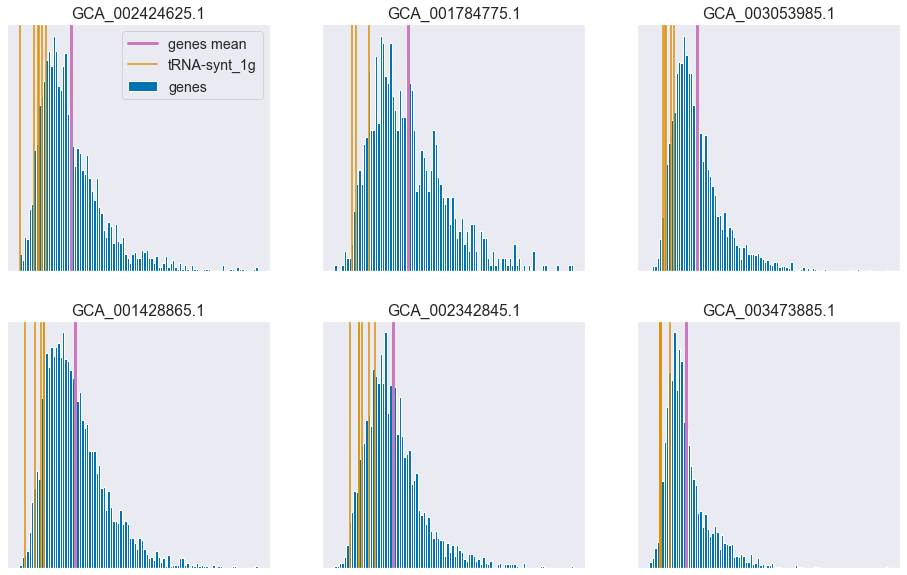

In [184]:
f = plot_domain_distances(
    assembly_df, 
    domain_query='tRNA-synt_1g', 
    query_type='pfam', 
    n_samples=6, 
    #phylum='Firmicutes',
    seed=99,
)
#f.savefig(
#    os.path.join(os.getcwd(), 'report/diagrams/trna_synt_1g_dist.eps'), 
#    bbox_inches='tight', 
#    dpi=300,
#)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


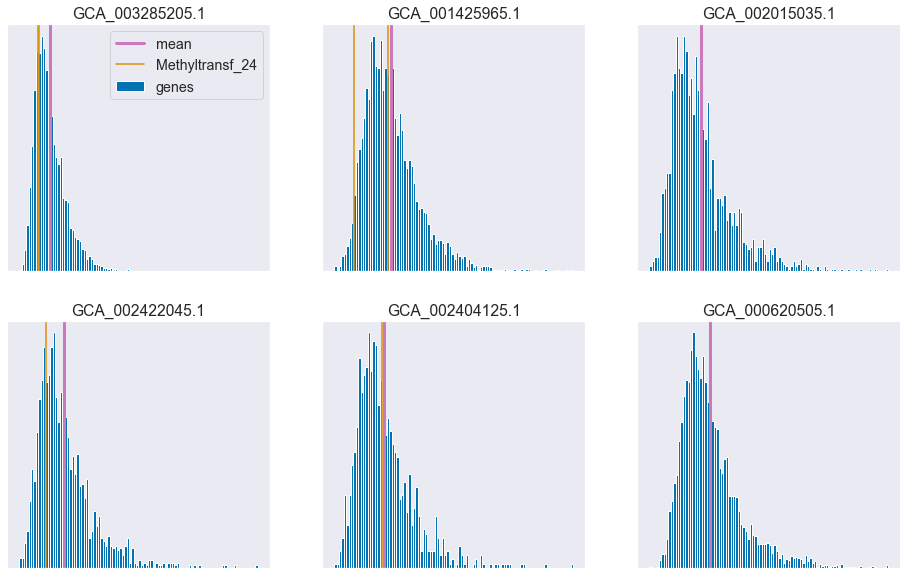

In [151]:
f = plot_domain_distances(
    assembly_df, 
    domain_query='Methyltransf_24', 
    query_type='pfam', 
    n_samples=6, 
    #phylum='Fibrobacteres',
    seed=444,
)
#f.savefig(
#    os.path.join(os.getcwd(), 'report/diagrams/methyltransf_24_dist.eps'), 
#    bbox_inches='tight', 
#    dpi=300,
#)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


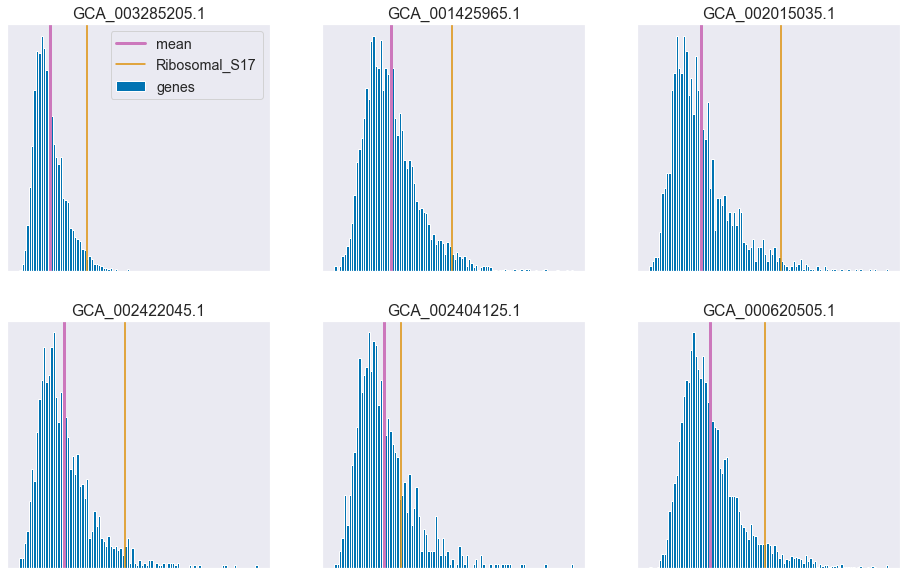

In [152]:
f = plot_domain_distances(
    assembly_df, 
    domain_query='Ribosomal_S17', 
    query_type='pfam', 
    tail='right',
    n_samples=6, 
    seed=444,
)
#f.savefig(
#    os.path.join(os.getcwd(), 'report/diagrams/ribosomal_s17.eps'), 
#    bbox_inches='tight', 
#    dpi=300,
#)

## Evidence count

In [10]:
def compute_evidence_count(assembly_df, query, query_type, tail):
    counts = collections.defaultdict(int)
    phyla = assembly_df['phylum'].unique()
    for i, phylum in enumerate(phyla):
        if pd.isnull(phylum):
            continue
            
        phylum_p = phylum.lower().replace(' ', '_')
            
        path = os.path.join(
            os.getcwd(),
            f'data/phylum/{phylum_p}/{phylum_p}_{query_type}_probability_left.csv',
        )
        if not os.path.isfile(path):
            continue
            
        df = pd.read_csv(path, index_col='query')
        try:
            evidence = df.loc[query]['evidence_strength']
            counts[evidence] += 1
        except KeyError:
            continue
            
    return dict(counts)

In [11]:
compute_evidence_count(assembly_df, 'tRNA-synt_1g', 'pfam', 'left')

{'Decisive': 40, 'Substantial': 3, 'Very Strong': 13, 'Strong': 12}

In [12]:
compute_evidence_count(assembly_df, 'tRNA-synt_1', 'pfam', 'left')

{'Decisive': 36, 'Weak': 1, 'Strong': 14, 'Very Strong': 10, 'Substantial': 7}

In [13]:
compute_evidence_count(assembly_df, 'Helicase_C', 'pfam', 'left')

{'Decisive': 51, 'Substantial': 3, 'Weak': 1, 'Strong': 7, 'Very Strong': 6}

In [154]:
10**(1.5)

31.622776601683793

## Distribution of log evidence 

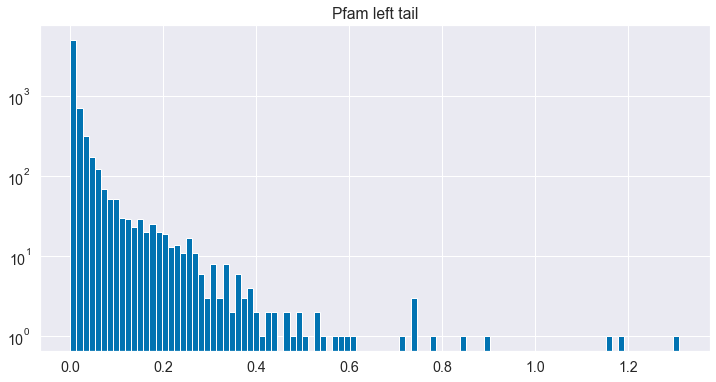

In [176]:
pfam_left_df = pd.read_csv(os.path.join(os.getcwd(), 'data/pfam_probability_left.csv'))
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist([v for v in pfam_left_df['evidence'] if v > 0], bins=100, log=True);
ax.set_title('Pfam left tail');

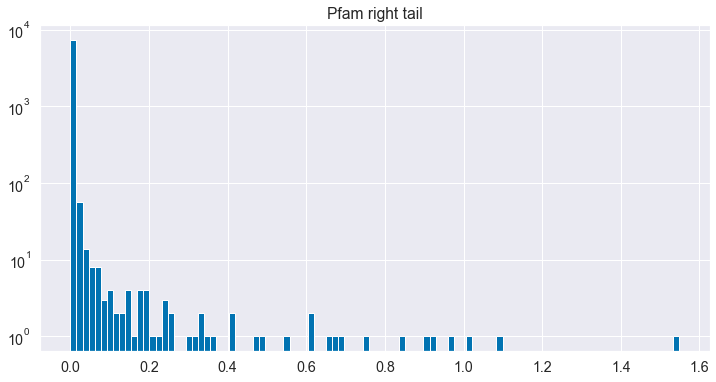

In [177]:
pfam_right_df = pd.read_csv(os.path.join(os.getcwd(), 'data/pfam_probability_right.csv'))
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist([v for v in pfam_right_df['evidence'] if v > 0], bins=100, log=True);
ax.set_title('Pfam right tail');

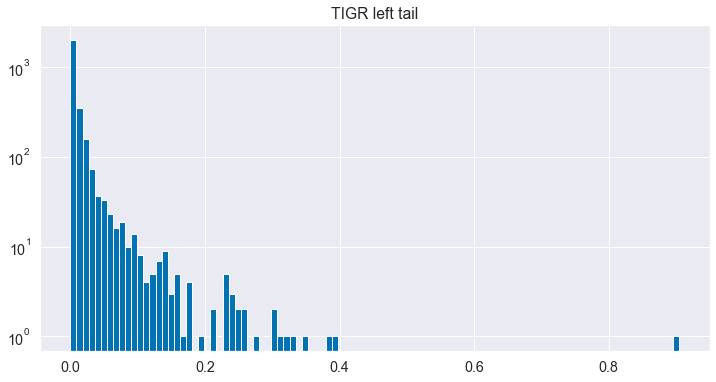

In [178]:
tigr_left_df = pd.read_csv(os.path.join(os.getcwd(), 'data/tigr_probability_left.csv'))
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist([v for v in tigr_left_df['evidence'] if v > 0], bins=100, log=True);
ax.set_title('TIGR left tail');

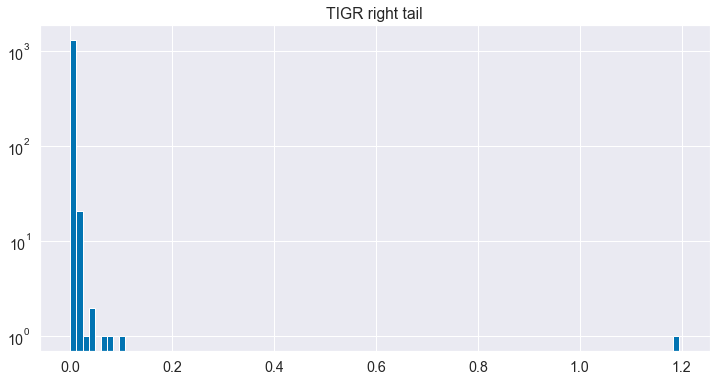

In [179]:
tigr_right_df = pd.read_csv(os.path.join(os.getcwd(), 'data/tigr_probability_right.csv'))
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.hist([v for v in tigr_right_df['evidence'] if v > 0], bins=100, log=True);
ax.set_title('TIGR right tail');

## Superkingdom results

In [182]:
query_types = ['pfam', 'tigr']
tails = ['left', 'right']
superkingdoms = ['bacteria', 'archaea']
for query_type in query_types:
    for tail in tails:
        overall_df = pd.read_csv(os.path.join(
            os.getcwd(),
            f'data/{query_type}_probability_{tail}.csv',
        ))
        overall_top_set = set(overall_df[overall_df['evidence'] > 0.5]['query'].values)
        
        for superkingdom in superkingdoms:
            print(query_type, tail, superkingdom)
            
            superkingdom_df = pd.read_csv(os.path.join(
                os.getcwd(),
                f'data/superkingdom/{superkingdom}/{superkingdom}_{query_type}_probability_{tail}.csv',
            ))
            
            superkingdom_top_set = set(superkingdom_df[superkingdom_df['evidence'] > 0.5]['query'].values)
            
            diff = sorted(superkingdom_top_set - (overall_top_set & superkingdom_top_set))
            print('Total:', len(superkingdom_top_set))
            print('Same: ', len(overall_top_set & superkingdom_top_set))
            print('Different: ', len(diff))
            print(diff)
            print()

pfam left bacteria
Total: 28
Same:  16
Different:  12
['AAA_19', 'EFG_C', 'GTP_EFTU_D2', 'HATPase_c', 'HD', 'HHH_6', 'HisKA', 'Hydrolase_3', 'IstB_IS21', 'Mur_ligase_M', 'Toprim', 'Transpeptidase']

pfam left archaea
Total: 40
Same:  15
Different:  25
['3Beta_HSD', 'AAA_14', 'AAA_16', 'AAA_22', 'Aminotran_1_2', 'DEAD', 'DUF87', 'Epimerase', 'FeoB_N', 'GDP_Man_Dehyd', 'Glyco_tranf_2_3', 'Glycos_transf_2', 'Intein_splicing', 'LAGLIDADG_3', 'Methyltransf_11', 'Methyltransf_25', 'NAD_binding_4', 'Polysacc_synt_2', 'Pyr_redox_2', 'RMMBL', 'Radical_SAM', 'RmlD_sub_bind', 'T2SSE', 'T2SSF', 'TGS']

pfam right bacteria
Total: 37
Same:  14
Different:  23
['HTH_19', 'HTH_3', 'HTH_31', 'IF3_C', 'Ribosomal_L11_N', 'Ribosomal_L12', 'Ribosomal_L12_N', 'Ribosomal_L16', 'Ribosomal_L17', 'Ribosomal_L18p', 'Ribosomal_L20', 'Ribosomal_L27', 'Ribosomal_L31', 'Ribosomal_L33', 'Ribosomal_L34', 'Ribosomal_L35p', 'Ribosomal_S16', 'Ribosomal_S18', 'Ribosomal_S20p', 'Ribosomal_S6', 'Ribosomal_S9', 'SecG', 'ribos